# Intro 

This notebook is dedicated to RL based approach to playing Spider Solitaire game. The training environment for an agent is made in `Gymnasium`-like manner. There are 3 difficulty levels in the game (1 suit, 2 and 4 suits). The goal is to arrange all the tableau cards into 8 sequences. 
The link to Kaggle notebook: [https://www.kaggle.com/code/zauberfloete/rl-applied-to-spider-solitaire-game/edit](http://www.kaggle.com/code/zauberfloete/rl-applied-to-spider-solitaire-game/edit) 

!git clone https://github.com/Klavierkonzert/RL.git
cd RL
cd SpiderSolitaire

In [ ]:
LOG_DIR = "./training/logs/"

import pandas as pd

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

import numpy.typing as npt
import typing
import time

from numba import njit

from IPython.display import clear_output

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


import threading
import queue
def timed_input(timeout: int=60, prompt: str='') -> str|None:
    """Read input with optional timeout. 
        Returns None if timeout expires, entered string if input was provided in time."""
    q = queue.Queue()
    def reader():
        try:
            q.put(input(prompt))
        except EOFError:
            q.put(None)

    t = threading.Thread(target=reader)
    t.daemon = True
    t.start()

    try:
        return q.get(timeout=timeout)
    except:
        return None

## Entropy in SpiderSolitaire



# Step 0: creating an environment for Spider game
In the beginning of the game, cards from 2 decks are dealt onto 8 piles so that 50 cards are left in the draw pile. Cards will be enumerated from 0 till 52, this is the internal representation, and an agent will see these piles in "vectorized" form. The suit is defined as i_card % 4, 0 -> Spades, 1 -> Hearts, 2 -> Clubs, 3 -> Diamonds. The rank will be defined as i_card % 13. 

## SpiderSpace to handle internal game mechanic  

In [3]:
## SpiderSpace for observations

import gymnasium as gym
from gymnasium import spaces

class SpiderSpace(gym.spaces.Box):
    NONCARD_VALUE = 0
    LOWEST_CARD = 1
    HIGHEST_RANK = 13
    HIGHEST_CARD = 4*HIGHEST_RANK
    HIDE_VALUE = - 2*(HIGHEST_CARD - LOWEST_CARD +1)
    
    N_PILES = 10 # +1 for undealt cards
    N_CARDS = 2*(HIGHEST_CARD - LOWEST_CARD + 1)
    N_STOCK_CARDS =  (N_CARDS// N_PILES//2) * N_PILES #50
    N_FACEDOWN_CARDS = N_CARDS - N_STOCK_CARDS - N_PILES#init number of facedown cards in the game, 44
    N_TARGETS = N_CARDS//(HIGHEST_RANK -LOWEST_CARD+1) #number of sequences to complete (A,2,...,10,J,Q,K)x8

    I_STOCK_PILE = N_PILES 
    I_FACEDOWN_CNTS = N_PILES +1
    I_DEPTHS_CNTS = N_PILES +2

    DTYPE = np.int8

    SUITS = {0:'♠', 1:'♥', 2:'♣', 3: '♦'}
    RANKS = {**{i: str(i) for i in range(2, 11)}, **{11: 'J', 12: 'Q', 13: 'K', 1: 'A'}}
    FANCY_CARDS = {   0: {1: '🂡', 2: '🂢', 3: '🂣', 4: '🂤', 5: '🂥', 6: '🂦', 7: '🂧', 8: '🂨', 9: '🂩', 10: '🂪', 11: '🂫', 12: '🂭', 13: '🂮'},
                      1: {1: '🂱', 2: '🂲', 3: '🂳', 4: '🂴', 5: '🂵', 6: '🂶', 7: '🂷', 8: '🂸', 9: '🂹', 10: '🂺', 11: '🂻', 12: '🂽', 13: '🂾'},
                      2: {1: '🃑', 2: '🃒', 3: '🃓', 4: '🃔', 5: '🃕', 6: '🃖', 7: '🃗', 8: '🃘', 9: '🃙', 10: '🃚', 11: '🃛', 12: '🃝', 13: '🃞'},
                      3: {1: '🃁', 2: '🃂', 3: '🃃', 4: '🃄', 5: '🃅', 6: '🃆', 7: '🃇', 8: '🃈', 9: '🃉', 10: '🃊', 11: '🃋', 12: '🃍', 13: '🃎'}
                  }
    
    def __init__(self, n_suits: int=4, counts_features:bool=True, maxsize: int = 64, 
                 vectorize: bool=False,
                 dtype=np.int8, seed: int|None=None):
        """
            :params:
                n_suits: number of suits in the game. The default value is 4 (Spades,...)
                counts_features: if True, the last 2 rows (features) of the space represent counts in the tableau piles + stock piles. In the beginning of a game counts are 5,5,5,5,4,4,4,...,4,50 for facedown carts and 1,...1 for max depths feature. 
                maxsize: max number of cards in one pile. Should not be lesser than N_STOCK_CARDS (50)
                vectorize: bool (False by default) - if True, adds a dimension to observation space spatial signature (N_PILES+..., maxsize) -> (N_PILES+..., maxsize, 4), which would yield more comprehensible for deep learning agents results. All the cards, represented internally as 1<=i<=52 cards will be represented as [0,..,i%13, 0] 4-vectors 
                dtype: preferred numpy dtatatype, set to int8 for efficiency
                seed: dummy seed param
            returns:
                np.array of shape (N_PILES+1+counts_feature, maxsize) of dtype
                """
        assert 1<=n_suits<=4
        assert maxsize>= SpiderSpace.N_STOCK_CARDS, "make sure maxsize is more than expected number of undealt cards (e.g. 50)"
        
        self.pile_size =maxsize
        self.n_suits = n_suits
        self.counts_features = counts_features

        if not vectorize or n_suits==1:
            shape = (SpiderSpace.N_PILES + 1 + 2*int(self.counts_features), maxsize)
        else:
            shape = (SpiderSpace.N_PILES + 1 + 2*int(self.counts_features), maxsize, n_suits)
        # if dtype==np.int8:
        low = min(SpiderSpace.LOWEST_CARD,SpiderSpace.NONCARD_VALUE)  + SpiderSpace.HIDE_VALUE
        high = n_suits * SpiderSpace.HIGHEST_RANK
                
        super().__init__(low=low,  high=high,  shape=shape,  dtype = dtype,  seed=seed)
        # else:
        #     low = np.full(shape, min(SpiderSpace.LOWEST_CARD,SpiderSpace.NONCARD_VALUE)  + SpiderSpace.HIDE_VALUE, dtype = dtype)
        #     high =np.full(shape, SpiderSpace.HIGHEST_CARD, dtype = dtype)
            
        #     super().__init__(low=low,  high=high,   dtype = dtype, seed=seed)
        
        #self.low, self.high = SpiderSpace.LOWEST_CARD + SpiderSpace.HIDE_VALUE, SpiderSpace.HIGHEST_CARD
    
    def sample(self, hide_cards: bool=True,
               __LOWEST_CARD=LOWEST_CARD, __HIGHEST_RANK=HIGHEST_RANK, __HIGHEST_CARD=HIGHEST_CARD, __NONCARD_VALUE=NONCARD_VALUE, __N_CARDS=N_CARDS, __CARDS_RANGE=-LOWEST_CARD+HIGHEST_RANK+1,
               __N_STOCK_CARDS=N_STOCK_CARDS, __N_PILES=N_PILES, __HIDE_VALUE=HIDE_VALUE,  
               __I_STOCK_PILE=I_STOCK_PILE, __I_FACEDOWN_CNTS=I_FACEDOWN_CNTS, __I_DEPTHS_CNTS=I_DEPTHS_CNTS,
               __DTYPE=DTYPE) -> npt.NDArray[np.integer]:
        """Generates a valid Spider preset in the form [n_piles, max_cards_per_pile].
            :params:
                hide_cards: if True, the cards in the stock pile (the last row) and the cards other than last in the tableau piles are considered as face-down, i.e. invisible to an agent. This is done by subtracting the HIGHEST_CARD.
                facedown_counts: if True, the last row[:N_PILES] in the returned numpy array is reserved to store counts of facedown cards in the tableau piles and stock pile (50). In the beginning of a game the counts are expected to be as follows: 6,6,6,6,5,5,5...,5, 50
            :returns:
                np.array of small (int8) integers"""
        #cards are represented by integers
        cards = np.arange(__LOWEST_CARD, self.n_suits*__HIGHEST_RANK +1, dtype=__DTYPE)
        cards = np.hstack([cards] * (__N_CARDS//(self.n_suits* __CARDS_RANGE)))
        np.random.shuffle(cards)
        empty_space = np.full(self.shape[:2], __NONCARD_VALUE, dtype=__DTYPE)

        n_undealt_cards = __N_STOCK_CARDS
        n_dealt_cards = len(cards) - n_undealt_cards
        
        #cards are dealt to piles sequentially, e.g. 6,6,6,6,5,5,5,5,5,5:
        min_cards_to_pile = n_dealt_cards//__N_PILES
        n_total_dealt_cards = 0
        for i in range(__N_PILES):
            n_cards_to_pile = min_cards_to_pile + (i< n_dealt_cards% __N_PILES)
            empty_space[i, :n_cards_to_pile ] += cards[n_total_dealt_cards: (n_total_dealt_cards := n_total_dealt_cards+ n_cards_to_pile )]

            #subtracting 104 if hide_cards:
            if hide_cards:
                empty_space[i, :n_cards_to_pile -1] += __HIDE_VALUE
            # count facedown cards in the last row if necessary
            if self.counts_features:
                empty_space[__I_FACEDOWN_CNTS, i] = n_cards_to_pile-1
                empty_space[__I_DEPTHS_CNTS, i] = 1
                
            
        # remaining cards in the draw pile (e.g. 50)
        empty_space[__N_PILES, :n_undealt_cards] = cards[-n_undealt_cards:] - 2*__HIGHEST_CARD if hide_cards else 0
        if self.counts_features:
            #assert self.pile_size==self.shape[1]>__N_STOCK_CARDS, "Make sure there is space for counts: the last row in the matrix should be reserved"
            empty_space[__I_FACEDOWN_CNTS, __N_PILES] = __N_STOCK_CARDS
                    
        return empty_space

    
    @staticmethod
    @njit(inline='always')
    def get_rank(cards, 
                 __LOWEST_CARD=LOWEST_CARD, __HIGHEST_RANK=HIGHEST_RANK,
                __RANKS_RANGE = HIGHEST_RANK  - LOWEST_CARD+1) -> int:
        #always positive
        return (cards - __LOWEST_CARD) % __RANKS_RANGE + __LOWEST_CARD 
    @staticmethod
    @njit(inline='always')
    def get_suit(cards, n_suits: int=4, 
                 __LOWEST_CARD=LOWEST_CARD, __HIGHEST_RANK=HIGHEST_RANK,
                __RANKS_RANGE = HIGHEST_RANK  - LOWEST_CARD+1) -> int:
        return  ((cards - __LOWEST_CARD) % (n_suits* __RANKS_RANGE)) // __HIGHEST_RANK

    @staticmethod
    @njit(inline='always')
    def is_valid_placement(moving_card, destination_card,  
                 __LOWEST_CARD=LOWEST_CARD, __HIGHEST_RANK=HIGHEST_RANK,
                __RANKS_RANGE = HIGHEST_RANK  - LOWEST_CARD+1) -> bool:
        """Checks whether it'spossible to move a `moving_card` onto a `destination_card`"""
        return (moving_card % __RANKS_RANGE >0) & ((destination_card - moving_card) % __RANKS_RANGE ==1)

        
    @staticmethod
    # @njit(inline='always')
    def card_to_str(card: int, ranks: dict|list=RANKS, suits:dict|list=SUITS) -> str:
        """card: int. If card<0, ' 🂠' is returned, if 0, then '  ' is returned"""
        return f"{ranks[SpiderSpace.get_rank(card)]}{suits[SpiderSpace.get_suit(card)]}" if card>0 else ' 🂠' if card<0 else '  '
    @staticmethod
    def card_to_fancy_str(card: int, fancy_cards: dict[dict[int, str]]=FANCY_CARDS) -> str:
        """card: int. If card<0, ' 🂠' is returned, if 0, then ' ' is returned"""
        return fancy_cards[SpiderSpace.get_suit(card)][SpiderSpace.get_rank(card)] if card>0 else '🂠' if card<0 else ' '
        
    @staticmethod
    def vectorize(state: npt.NDArray[np.integer], n_suits: int=4, _counts_features: bool=True,
                 __NONCARD_VALUE=NONCARD_VALUE, __N_PILES=N_PILES,
                 __I_STOCK_PILE=I_STOCK_PILE, __I_FACEDOWN_CNTS=I_FACEDOWN_CNTS, __I_DEPTHS_CNTS=I_DEPTHS_CNTS
                 ) -> npt.NDArray[np.integer]:
        """Each card number in the space/state is translated into a 4-vector, e.g. Ace of Spades -> [1,0,0,0], King of Hearts -> [0,13,0,0]. The output has the same number of dimensions as the input +1.
        This function does not handle states with the last row reserved for facedown cards counts. Use `_counts_features=True` to recalculate these counts for "vectorized" cards.
        The function is called when vectorized cards are requested by `SpiderEnv` constructor (the argument `vectorize_obs` passed to `SpiderSpace` constructor) in order to represent agent's observations by a 3D tensor.
            :params:
                state: numpy array 
                n_suits: number of suits in the game (1,2,3,4)
                _counts_features: if True, the last but one row-tensor is reserved to count face-down cards (negative numbers if any), and the last one stores max depths of top cards sequences per each pile
                                Should be put False if tableau piles are input as state
        """
        nonzero_idc = np.nonzero(state - __NONCARD_VALUE) # 2-tuple (rows_idc, cols_idc)
        ##ranks and suits of nonzero cards (1D arrays)
        nonzero_cards = state[nonzero_idc] # np.copy(state[nonzero_idc])
        #nonzero_cards[nonzero_cards<0] -= SpiderSpace.HIDE_VALUE 
        suits_idc = SpiderSpace.get_suit(nonzero_cards, n_suits) # i.e. Spades -> 0, ...
        ranks = SpiderSpace.get_rank(nonzero_cards)  * np.sign(nonzero_cards)
        
        empty_space = np.full((*state.shape, n_suits), __NONCARD_VALUE, dtype=state.dtype) 
        empty_space[*nonzero_idc, suits_idc] = ranks

        if _counts_features: 
            #the last but one row for face-down cards counts (also stock pile, i.e. N_PILES+1 counts)
            empty_space[__I_FACEDOWN_CNTS, :__N_PILES+1] = SpiderSpace.get_facedown_counts(empty_space[:__I_STOCK_PILE+1])# np.count_nonzero(empty_space[:, :-1], axis=1)
            empty_space[__I_DEPTHS_CNTS, :__N_PILES]   = SpiderSpace.get_max_sequences_depths(empty_space[:__N_PILES])
            
        return empty_space
        
    def devectorize() -> npt.NDArray[np.integer]:
        ...

    @staticmethod
    def _pad_matrix(matrix, arithmetic_axis:int=1, 
                    __NONCARD_VALUE=NONCARD_VALUE):
        return np.pad(matrix,  
                      [(0,0)]*arithmetic_axis + [(0,1)] + [(0,0)]*(matrix.ndim-arithmetic_axis-1), constant_values=__NONCARD_VALUE)
    @staticmethod
    def get_top_cards_indices(tableau_piles: npt.NDArray[np.integer],
                              _return_difference: bool=False,
                                __NONCARD_VALUE=NONCARD_VALUE) -> npt.NDArray[np.integer]:
        """this method could be useful...
                returns positions of sequences (1 card or elements of ordered sequences) which can be moved to another pile.
                The output is `np.array` of shape `(N_PILES,)`
            params:
                tableau_piles: the first N_PILES of game state (tableau piles)
                _return_difference: if True, the function returns the tuple `(cards_indices, differences)`, where `differences` represents shifted differences between cards per each pile. The latter is used by `get_max_sequences_depths(tableau_piles)` function.
                Example:
                >>> SpiderSpace.get_top_cards_indices(np.array([[1,4,3,15,14,13,12,0,0],
                            [1,4,3,16,15,13,12,0,0],
                              [1,4,3,2,16,15,14,0,0],
                              [3,2,1,0,0,0,0,0,0],
                                [0,0,0,0,0,0,0,0,0],
                              [2,3,1,0,0,0,0,0,0],
                              [16,15,14,0,0,0,0,0,0],
                              [1,4,9,9,5,4,3,-2,9]]))
                (array([0, 1, 2, 3, 5, 6, 7]), array([6, 6, 6, 2, 2, 2, 8]))
        """
        #determining arithmetic axis
        ar_axis = int(len(tableau_piles.shape)>1) #0 if tableau_piles is 1D array, 1 otherwise
        #difference between cards per each pile (to detect ascending sequences (-1))
        padded_tableau = SpiderSpace._pad_matrix(tableau_piles, ar_axis) 
        d = np.diff(padded_tableau, axis=ar_axis)# will be truncated
        idc_topcards = np.nonzero(d - __NONCARD_VALUE)
    
        mask = np.append(np.diff(idc_topcards[0]), 1).astype(bool) 
        bnd_coords = tuple(bnd_ax[mask] for bnd_ax in idc_topcards)
        return bnd_coords if not _return_difference else (bnd_coords, d)#[:,:-1])
        
    @staticmethod
    def get_max_sequences_depths(tableau_piles: npt.NDArray[np.integer],
                                    __HIGHEST_CARD = HIGHEST_CARD, __NONCARD_VALUE=NONCARD_VALUE, __HIDE_VALUE=HIDE_VALUE,
                                    __DTYPE=DTYPE
                                    ) -> npt.NDArray[np.integer]:
        """Accepts a valid game state (tableau piles). Supports also a vactorized form of tableau_piles (in this case returns 3D tensor with depths corresponding to a top suit cards)
            Instance for 3D case:
                >>> SpiderSpace.get_max_sequences_depths(SpiderSpace.vectorize(np.array([
                        [1,4,3,15,14,13,12,0,0],
                        [1,4,3,16,15,13,12,0,0],
                          [1,4,3,2,16,15,14,0,0],
                          [3,2,1,0,0,0,0,0,0],
                          [2,3,1,0,0,0,0,0,0],
                          [16,15,14,0,0,0,0,0,0],
                          [1,4,9,9,5,4,3,-2,9]]), _counts_features=False))
                array( [[2, 0, 0, 0],
                        [2, 0, 0, 0],
                        [0, 3, 0, 0],
                        [3, 0, 0, 0],
                        [1, 0, 0, 0],
                        [0, 3, 0, 0],
                        [1, 0, 0, 0]])
            Returns an array each position of which is max number of cards in the sequence it is possible yo move to another pile. Bounded by 1 and 12.
        """
        ar_axis = int(len(tableau_piles.shape)>1) #0 if tableau_piles is 1D array, 1 otherwise
        #difference between cards per each pile (to detect ascending sequences (-1))
        #print(tableau_piles)
        d = np.diff(tableau_piles, axis=ar_axis)# will be truncated
        idc_topcards = np.nonzero(d - __NONCARD_VALUE)

        if ar_axis:
            #print(d[:,:10,:])
            mask = np.append(np.diff(idc_topcards[0]), 1).astype(bool) 
            bnd_coords = tuple(bnd_ax[mask] for bnd_ax in idc_topcards)
            
            # print(bnd_coords)
            #selecting zero diffs before bnds (when cards are of same rank) and hiding them:
            #cols_mask = (np.arange(d.shape[1], dtype=__DTYPE) < bnd_coords[1][:,None]) & np.all(d==0, axis=ar_axis+1)# (d.shape[0],d.shape[1])
            
            # print(d[:2])
            if len(tableau_piles.shape)>2:
                #cols_mask = (np.arange(d.shape[1], dtype=__DTYPE) < bnd_coords[1][:,None])[...,None] & (d[bnd_coords[0]]==__NONCARD_VALUE)
                cols_mask = (np.arange(d.shape[1], dtype=__DTYPE) < bnd_coords[1][:,None]) & np.all(d[bnd_coords[0]]==__NONCARD_VALUE, axis=-1)
                
                r, c, *_rest_dim = np.nonzero(cols_mask)
            else: 
                # print(bnd_coords)
                # print(np.arange(d.shape[1], dtype=__DTYPE) < bnd_coords[1][:,None])
                # print(d)
                cols_mask = (np.arange(d.shape[1], dtype=__DTYPE) < bnd_coords[1][:,None]) & (d[bnd_coords[0]]==__NONCARD_VALUE)
                r, c = np.nonzero(cols_mask)
                
            # print(np.squeeze(np.all(d==0, axis=1)))
            #print(cols_mask)
            
            d[bnd_coords[0][r], 
                c, 
                tuple(bnd_coords[i][r] for i in range(2,len(tableau_piles.shape))) if len(tableau_piles.shape)>2 else None
            ] = __HIDE_VALUE
            #print("final indices which vals to be assigned to HIDE_VALUE : ", bnd_coords[0][r], *c)
        
        else: #for 1D arrays
            if len(idc_topcards[0])>0:
                bnd_coords = idc_topcards[0][-1]
                
                #selecting zero diffs before bnds (when cards are of same rank) and hiding them:
                cols_mask = (np.arange(d.shape[0])<bnd_coords) & (d==0)# (d.shape[1],)
                d[cols_mask] = __HIDE_VALUE
            else:
                return 0 # the array (pile) is completely empty (0-filled)
        #suits difference
        sd = np.diff(SpiderSpace.get_suit(tableau_piles), axis=ar_axis).astype(bool) # True if two cards are of different suit
        d[sd & (d==-1)] -= __HIGHEST_CARD #subtracts 52 from -1 at the edge of a valid sequence diff([3,2,1,0])=[-1,-1,-1], so that -1 -1 -1 -> -1 -1 -10 and will yield depth=3 
        # bnd_rows, bnd_cols, ... contain coords of right non-zeros (bounds)
        # assigning right bounds of every pile with -1 if the next card in a pile is greater by one
        d[bnd_coords] = np.where(d[bnd_coords] < __NONCARD_VALUE, -1, +1)
        
        d[np.nonzero(d==-1)] = __NONCARD_VALUE
        #print(d)
        consequtive_zeros = (np.flip(d, axis=ar_axis)==__NONCARD_VALUE).cumprod(axis=ar_axis).sum(axis=ar_axis)
        # depths = n consequitive zeros - n of zeros in the tableu_piles
        depths = consequtive_zeros- (np.flip(tableau_piles, axis=ar_axis)==__NONCARD_VALUE).cumprod(axis=ar_axis).sum(axis=ar_axis)+1 # subtracting num of zeros in tableau_piles
        return depths

    @staticmethod
    @njit(inline='always')
    def get_facedown_counts(piles: npt.NDArray[np.integer]) -> npt.NDArray[np.integer]:
        """piles: tableau piles and stock pile state matrix. 
            Returns number of face-down cards"""
        return np.count_nonzero(piles*(piles<0), axis=1)

        
    # @staticmethod
    # def validate(state: npt.NDArray[np.integer], facedown_cards: bool=True, facedown_counts: bool=True) -> bool:
    #     """Validate the state/space. 
    #         :params:
    #             facedown_cards: if True, negative values are included in range checks
    #             #facedown_counts: if True and facedown_cards, the last row is checked to contain number of negative values in every column"""
    #     state_orig = state
    #     state=np.array(state)
    #     if facedown_counts: 
    #         state[-1] = 0
    #     if facedown_cards:
    #         state[state<0] -= SpiderSpace.HIDE_VALUE    

    #     #print(state)
    #     nonzero_idc = np.nonzero(state - SpiderSpace.NONCARD_VALUE)
    #     nonzero_cards = state[nonzero_idc]
    #     #print(len(nonzero_cards), len(set(nonzero_cards)))
    #     nonzero_cards = nonzero_cards.flatten()
    #     unique_cards = np.unique(nonzero_cards)
    #     #print(np.count_nonzero(state, axis=1))
    #     #print(state_orig*(state_orig<0))
    #     return (len(nonzero_cards) == 2*len(unique_cards) <= 2*SpiderSpace.N_CARDS
    #             and np.all((SpiderSpace.LOWEST_CARD <=unique_cards) & (unique_cards <=SpiderSpace.HIGHEST_CARD)) 
    #             and ((np.all((cnts:=SpiderSpace.calculate_facedown_counts(state_orig[:-1]))==state_orig[-1, :len(cnts)]) if facedown_cards and facedown_counts else True))
    #            )

    @staticmethod
    #@njit(inline='always')
    # works well with 2D but higher dimensions are supported poorly
    def left_align_rows(state: npt.NDArray[np.integer], __NONCARD_VALUE=NONCARD_VALUE) -> npt.NDArray[np.integer]:
        """"shifts rows (piles) with zeros left. For example, [[0,1,0,2], [-9,0,8,0]] -> [[1,2,0,0],[9,0,-8,0]]
            Do not apply this transformation for the last two rows (stock pile and facedown counts)"""
        # if len(state.shape)>2 :
        #     print(np.argsort(np.any(state!=__NONCARD_VALUE, axis=2)[:,None]))
        # return np.take_along_axis(state, 
        #                           np.argsort(np.any(state!=__NONCARD_VALUE, axis=1)[:,None] if len(state.shape)>2 else state, axis=1),
        #                           axis=1)#(((state[:,0]!=__NONCARD_VALUE) | (np.count_nonzero(state, axis=1)==0))), axis=1)
        if len(state.shape)>2 :
            zero_mask = ~np.any(state, axis=-1)
        elif len(state.shape)==2:
            zero_mask = ~state.astype(bool)
        else:
            raise NotImplementedError("Not implemented for {len(state.shape)} numpy-arrays")
        shift = np.argmax(~zero_mask, axis=1)
        return state[np.arange(state.shape[0])[:, None], 
                        (np.arange(state.shape[1]) + shift[:,None]) % state.shape[1] ]
        

In [4]:
SpiderSpace.is_valid_placement(12+14,13+14)

False

In [5]:
state = np.array([[[0,0,1,0],[0,0,0,0],[0,0,0,0], [0,8,0,0]], 
                  [[0,0,1,0],[0,0,0,0],[0,0,0,0], [0,0,0,0]], 
                  [[0,0,0,0],[0,0,0,0],[0,0,0,0], [0,0,0,0]],
                  [[0,0,1,0],[0,0,0,0],[9,9,0,0], [0,0,0,0]], 
                  [[0,0,0,0],[9,9,0,0], [999,0,0,0],[0,0,0,0]],#shift by 1 position left
                  [[0,0,0,0],[0,0,0,0], [9,9,0,0], [999,0,0,0]] # shift by 2 pos left
                 ])
SpiderSpace.left_align_rows(state)

array([[[  0,   0,   1,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   8,   0,   0]],

       [[  0,   0,   1,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   1,   0],
        [  0,   0,   0,   0],
        [  9,   9,   0,   0],
        [  0,   0,   0,   0]],

       [[  9,   9,   0,   0],
        [999,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  9,   9,   0,   0],
        [999,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]]])

In [6]:
rows = np.array([0,1])
cols=np.array([0,1])
v = np.array([[22,3,34],
             [444,555,666]])
v[rows, np.array([[0,1],
                  [1,2]])]
v[0,1,None]=99
v

array([[ 22,  99,  34],
       [444, 555, 666]])

In [7]:
SpiderSpace.get_facedown_counts(np.array([[[-1,2],[3,9]], 
                                              [[-21,-23],[4,-4]]]))

array([[1, 0],
       [1, 2]])

### some mehods

In [8]:

spider = SpiderSpace(maxsize=50)
s = spider.sample()
# while not np.any(s[-1]==2):
#     s = spider.sample()
# # sorted(s.flatten())
np.count_nonzero(s, axis=1)
s[0, 0:2]=17+13
s[0, 2:4]=16+13
s[0, 4:6]=20
s[0, 6:7]=19

s[1, 4:6]=19
s[1, 2:4]=20+13
print(s[:2])
sv = SpiderSpace.vectorize(s, _counts_features=False)
SpiderSpace.get_max_sequences_depths(sv[:10])

[[ 30  30  29  29  20  20  19   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [-79 -61  33  33  19  19   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


array([[0, 2, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [9]:
SpiderSpace.left_align_rows(np.array([[0,1,0,2], 
                                      [9,0,-8,0]])) # works well with 2D but higher dimensions are supported poorly

array([[ 1,  0,  2,  0],
       [ 9,  0, -8,  0]])

In [10]:
# Getting top cards idcs and seq depths

import numpy as np
tableau_piles1D = np.array([1,4,3,15,14,13,12,0,0])

tableau_piles2D = np.array([[1,4,3,15,14,13,12,0,0],
                            [1,4,3,16,15,13,12,0,0],
                              [1,4,3,2,16,15,14,0,0],
                              [3,2,1,0,0,0,0,0,0],
                                [0,0,0,0,0,0,0,0,0],
                              [2,3,1,0,0,0,0,0,0],
                              [16,15,14,0,0,0,0,0,0],
                              [1,4,9,9,5,4,3,-2,9]])

tableau_piles3D = SpiderSpace.vectorize(tableau_piles2D, _counts_features=False)
#print(np.diff(tableau_piles3D, axis=1))
#@njit(inline='always')

# print(SpiderSpace.vectorize(tableau_piles, facedown_counts=False))
print(SpiderSpace.get_max_sequences_depths(tableau_piles3D))#SpiderSpace.vectorize(tableau_piles, facedown_counts=False))
#get_max_sequences_depths(SpiderSpace.vectorize(tableau_piles, facedown_counts=False))

#tableau_piles[get_top_cards_incides(tableau_piles)]
idc = SpiderSpace.get_top_cards_indices(tableau_piles3D)
# tableau_piles2D[idc]

# get_max_sequences_depths(tableau_piles2D)
idc

[[2 0 0 0]
 [2 0 0 0]
 [0 3 0 0]
 [3 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 3 0 0]
 [1 0 0 0]]


(array([0, 1, 2, 3, 5, 6, 7]),
 array([6, 6, 6, 2, 2, 2, 8]),
 array([0, 0, 1, 0, 0, 1, 0]))

### Class for Actions


## SpiderEnv for environment

In [36]:
class SpiderEnv(gym.Env):
    """Introduction (Wikipedia):
    
        The main purpose of the game is to remove all cards from the table, assembling them in the tableau before removing them.
        Initially, 54 cards are dealt to the tableau in ten piles, face down except for the top cards. 
        The tableau piles build down by rank, and in-suit sequences can be moved together. 
        The 50 remaining cards can be dealt to the tableau ten at a time when none of the piles are empty.

        A typical Spider layout requires the use of two decks. 
        The tableau consists of 10 stacks, with 6 cards in the first 4 stacks, with the 6th card face up, and 5 cards in the remaining 6 stacks, with the 5th card face up. 
        Each time the stock is used, it deals out one card to each stack.
    """
    
    N_PILES = SpiderSpace.N_PILES # +1 for undealt cards
    N_TARGETS = SpiderSpace.N_TARGETS
    NONCARD_VALUE = SpiderSpace.NONCARD_VALUE
    metadata = {"render.modes": ["human"]}

    DEFAULT_REWARDS = {"complete sequence": 100.0,
                       "victory": N_PILES*100.0,
                       'step':-0.2,
                       "NOOP": -0.4,
                      "discover card": 8.0,
                      "extend sequence": 2.0,
                      "deal cards": 0.,
                      "free pile": 32,
                      'no available actions': -100,
                       "reward limit": 200
                      }
    # no needto keep this dict, as only one limit matters (for extending sequences)
    # DEFAULT_REWARDS_LIMITS = {"complete sequence": 100.0,
    #                   "discover card": 8.0 *SpiderSpace.N_FACEDOWN_CARDS,
    #                   "extend sequence": N_TARGETS*(SpiderSpace.HIGHEST_RANK - SpiderSpace.LOWEST_CARD)*DEFAULT_REWARDS["extend sequence"],
    #                   "deal cards": 0.
    #                          }

    MOVE_ACTIONS_RANGE = N_PILES*(N_PILES)*(SpiderSpace.HIGHEST_RANK -1)
    DEAL_CARDS_ACTION = MOVE_ACTIONS_RANGE
    NOOP_ACTION = DEAL_CARDS_ACTION +1 # It's possible in Spider Solitaire game that there are no available actions (game over)
    ACTIONS_RANGE = NOOP_ACTION+1
    
    def __init__(self, n_suits: int=4, n_actions_limit:int=None, 
                 vectorize_obs: bool=False,
                 mask_legal_actions:bool=False,
                 rewards_policy: dict[str, float]=None,
                 rewards_limits:dict[str, float]=None,
                 _render_state_timeout:int=None, _diagnostics_mode:bool=False,
                 _maxsize: int = 64, _dtype=np.int8):
        """"...
        :params:
            n_suits: int=4 - number of suitzs in the game. Popular options are 1, 2 and 4 (can be thought as difficulty levels)
            n_actions_limit:int=None - maximum number of actions an agent can perform in single game before it's restarted and a new game is generated
            vectorize_obs: bool=False - if True, `_get_obs` method yields observations in 3D-form array (thus each card is represented by a [0,...,rank,..,0] 4-vector), this does not affect interna enviroment calculations which are done in 2D (i.e. each card is represented by an integer)
            mask_legal_actions: bool=False - if True, each `step` a mask for legal moves is computed within `_get_info` method
                 
            _render_state_timeout:int=None 
            _maxsize: int = 64, _dtype=np.int8
        """
        self.observation_space = SpiderSpace(n_suits=n_suits, maxsize=_maxsize, 
                                             vectorize=vectorize_obs, dtype=_dtype)
        # possible actions are: 1) move a sequence of cards from pile A to pile B on the table (the length can be 1,...,12), so 10*9*12 options
        # 2) deal 10 cards from stock pile, this is the last action
        self.action_space = gym.spaces.discrete.Discrete(SpiderEnv.ACTIONS_RANGE)

        self.internal_state, self.tableau_piles, self.stock_pile = None,None,None
        # self.facedown_cards, self.stock_cards = [], -1
        
        self.complete_sequences = 0#{i:0 for i in range(n_suits)} # Agent's goal is to complete all suits
        
        # n_actions_limit could be necessary to limit number of episodes in a game
        self.actions_limit = n_actions_limit
        self.actions_counter=0
            
        self.stock_len = SpiderSpace.N_STOCK_CARDS
        # self.facedown_tableu_cards=SpiderSpace.N_CARDS - SpiderSpace.N_STOCK_CARDS

        self._render_state_timeout, self._diagnostics_mode =_render_state_timeout, _diagnostics_mode

        self.episode_over = False

        self.mask_legal_actions = mask_legal_actions

        if rewards_policy is not None:
            self.rewards_policy = {**SpiderEnv.DEFAULT_REWARDS ,**rewards_policy}
        else:
            self.rewards_policy = SpiderEnv.DEFAULT_REWARDS 

        if rewards_limits is not None:
            # if set, rewards are extracted every time from these limits
            self.rewards_limits=rewards_limits

    def reset(self,seed: int|None=None, return_info=True, options=None):
        super().reset(seed=seed) # np_seed

        self.episode_over = False
        
        self.actions_counter = 0
        self.complete_sequences = 0
        
        self.internal_state = self.observation_space.sample(hide_cards = True)
        
        self.tableau_piles, self.stock_pile, self.counts, self.seq_depths = self._unpack_state(self.internal_state)
        
        self.stock_len = SpiderSpace.N_STOCK_CARDS
        
        #initial visible observation
        obs = self._get_obs()
        info = self.get_info()
        return  obs, info #(obs, info) if return_info else obs
        
    #@staticmethod
    #@njit(inline='always')
    def _get_obs(self,# _vectorize:bool=True,
                __N_PILES=N_PILES, __I_FACEDOWN_CNTS=SpiderSpace.I_FACEDOWN_CNTS, __DTYPE=SpiderSpace.DTYPE) -> npt.NDArray[np.integer]:
        #last feature (row, pile) -> num of facedown cards (6,6,6,6,5,5,..., 50) in the beggining of a game 
        #piles 0,...,N_PILES-1 -> tableau piles
        #pile N_PILES -> stock pile
        obs_state = self.internal_state
        if len(self.observation_space.shape)==3:
            #recalcs FACEDOWN_COUNTS and DEPTH_COUNTS
            obs_state = SpiderSpace.vectorize(self.internal_state, _counts_features=True)
            # after vectorization agent can see how many facedown cards belong to each suit, 
            # this info should not be available:
            obs_state[__I_FACEDOWN_CNTS] =  obs_state[__I_FACEDOWN_CNTS].sum(axis=1)[:,None]
            
        obs_state = obs_state*(obs_state>0) #masking facedown cards
        obs_state[:__N_PILES] = SpiderSpace.left_align_rows(obs_state[:__N_PILES])
        
        if self.observation_space.dtype!=__DTYPE:
            obs_state = obs_state.astype(self.observation_space.dtype)
        return obs_state
        
    def get_info(self) -> dict[str,typing.Any]:
        d = {'n_complete_sequences' : self.complete_sequences,
            'n_facedown_tableu_cards': self.facedown_tableu_cards,
            'n_remaining_stock_cards': self.stock_len
        }
        #if self.mask_legal_actions:
        #     d['action_mask'] = self.get_action_mask()
        return d


    def _get_reward(self, action:int, 
                    terminated, truncated,
                    tableau_piles,
                    n_completed_seqs, 
                    init_stock_cards,
                    init_facedown_cnts, facedown_counts,
                    init_depths,        seq_depths,
                    init_tableau_cards,
                    __N_TARGETS=N_TARGETS, __NONCARD_VALUE=NONCARD_VALUE, 
                    __MOVE_ACTIONS_RANGE=MOVE_ACTIONS_RANGE, __DEAL_CARDS_ACTION = DEAL_CARDS_ACTION, __NOOP_ACTION=NOOP_ACTION
                   ) -> float:

        reward= 0
        if action is not None:
            if n_completed_seqs:
                reward += self.rewards_policy['complete sequence']*(n_completed_seqs)
                    
            reward += self.rewards_policy['discover card']*(init_facedown_cnts - facedown_counts[:__N_TARGETS]).sum()
            if action<=__MOVE_ACTIONS_RANGE: #if not deal cards action
                # seq depth is increased
                reward += self.rewards_policy['extend sequence']*(init_depths - seq_depths).sum()
                
                # reward for freeing a pile
                tab_cards = np.count_nonzero(tableau_piles-__NONCARD_VALUE, axis=1)
                n_freed_piles = ((tab_cards==0) & (tab_cards-init_tableau_cards<1)).sum()
                
                #reward+= self.rewards_policy["free pile"]*n_freed_piles
                #to inttroduce this reward, prevent an agent from moving sequences back and forth

            elif action==__DEAL_CARDS_ACTION and "deal cards" in self.rewards_policy and self.rewards_policy["deal cards"]!=0:
                # punish for dealing cards:
                coefff =  self.rewards_policy["deal cards"]
                if type(coefff)==tuple:
                    deal_cards_reward = SpiderEnv.deal_cards_reward(init_stock_cards, init_facedown_cnts, init_depths,
                                                                       *coefff )
                else:
                    deal_cards_reward = SpiderEnv.deal_cards_reward(init_stock_cards, init_facedown_cnts, init_depths,
                                                                       coeff=coefff )
                reward += deal_cards_reward
                #print debug info:
                if self._diagnostics_mode>=2 or self._diagnostics_mode>=1.5 and self._render_state_timeout is not None and self._render_state_timeout>0 :
                    print(f"Punishment/reward for dealing cards: {deal_cards_reward}")
                    self.render(print_auxillary_info=True)
                    
            ##punishment if no available actions left
            #elif  action==__NOOP_ACTION and not terminated and "no available actions" in self.rewards_policy : 
            #    reward += self.rewards_policy['no available actions'] *(__N_TARGETS-self.complete_sequences )* ((self.actions_limit-self.actions_counter)/self.actions_limit if self.actions_limit is not None else 1)
            elif  action==__NOOP_ACTION and not terminated and "no available actions" in self.rewards_policy:
                reward +=self.rewards_policy['NOOP']
            
            if 'step' in self.rewards_policy:
                reward += self.rewards_policy['step'] # punisment for a step
                
        # else:
        #     reward -= 010 #punishment for invalid action
    

            
        # #punishment for losing game
            # if truncated:
            #     reward -= (__N_TARGETS-self.complete_sequences)**2 
        # reward for victory:
        if self.complete_sequences == __N_TARGETS and 'victory' in self.rewards_policy:
            reward += self.rewards_policy['victory']

        return reward


            
    def step(self, action:int,
            __N_TARGETS=N_TARGETS, __NONCARD_VALUE=NONCARD_VALUE, 
            __NOOP_ACTION=NOOP_ACTION)-> tuple:
        """"""
        assert self.complete_sequences < __N_TARGETS #and (self.actions_limit is None or self.actions_limit is not None and self.actions_limit-self.actions_counter>=-1)

        if self.episode_over:
            obs, info = self.reset()
            if self.actions_limit is not None and 0<self.actions_limit==self.actions_counter:
                return obs, 0.0, False, True, info
            else:
                return obs, 0.0, True, False, info
        else:
            self.actions_counter+=1
    
            tableau_piles, stock_pile, facedown_counts, seq_depths = self._unpack_state(self.internal_state)

            init_stock_cards = np.count_nonzero(stock_pile-__NONCARD_VALUE)
            init_tableau_cards = np.count_nonzero(tableau_piles-__NONCARD_VALUE, axis=1)
            
            init_complete_seqs = self.complete_sequences
            init_facedown_cnts = facedown_counts[:__N_TARGETS].copy()
            init_depths = seq_depths.copy()

            #perform chosen action:
            action_res= self.num2act(action)
            # number of completed sequences. Usually 0, sometimes 1, more on rare occasions
            n_completed_seqs= self.discard_complete_sequences()
            
            truncated = self.actions_limit is not None and self.actions_limit==self.actions_counter
    
            #the game is finished once all the sequences are collected (8) or max number of actions is reached
            #done = sum(self.complete_sequences.values()) == __N_TARGETS or self.n_actions_limit is not None and self.actions_counter==self.n_actions_limit
            terminated = truncated or (self.complete_sequences == __N_TARGETS) & action==__NOOP_ACTION 

            
            # reward will be based on number of completed sequences            
            reward = self._get_reward(action if action_res else None,
                                      terminated, truncated,
                                      tableau_piles,
                                      n_completed_seqs,
                                      init_stock_cards,
                                      init_facedown_cnts, facedown_counts,
                                      init_depths,        seq_depths,
                                      init_tableau_cards)
            if reward>(self.rewards_policy["complete sequence"]//4) and self._diagnostics_mode>0.75 or reward>self.rewards_policy["complete sequence"]//2 and self._diagnostics_mode>2:
                print('action ', self._unflatten_move_action(action)if  0<=action<self.action_space.n else action)
                print('reward',  reward)
                
            if "reward limit" in self.rewards_policy and reward>self.rewards_policy["reward limit"]:
                raise Exception(f"Too large reward detected: {reward}, diagnostic data: ", terminated, truncated,tableau_piles,
                                      n_completed_seqs,
                                      init_stock_cards,
                                      init_facedown_cnts, facedown_counts,
                                      init_depths,        seq_depths,
                                      init_tableau_cards)
            #if self._diagnostics_mode>=1 and action==__NOOP_ACTION:
                
                
                
            obs = self._get_obs()
            
            info = self.get_info()
    
            if self._render_state_timeout is not None and self._render_state_timeout>0 and self.actions_counter % self._render_state_timeout==0:
                self.render(print_auxillary_info=self._diagnostics_mode>=1, show_agents_obs=self._diagnostics_mode>=2)
                print(f"terminated: {terminated}, truncated: {truncated}")
                #print(f"Vectorized state: {SpiderSpace.vectorize(self.internal_state)}")

            self.episode_over = terminated or truncated
            return obs, reward, terminated, truncated, info

    def get_game_status(self,__N_TARGETS= N_TARGETS)-> bool:
        """Returns True if game is won, False otherwise"""
        return self.complete_sequences==__N_TARGETS
        
    ##############################################
    # possible actions function 
    # each returns True if action is valie, else False

    def get_action_mask(self,
                        __RANKS_RANGE= SpiderSpace.HIGHEST_RANK - SpiderSpace.LOWEST_CARD+1,
                        __DEAL_CARDS_ACTION = DEAL_CARDS_ACTION, __NOOP_ACTION=NOOP_ACTION
                       ) -> npt.NDArray[bool]:
        actions_mask = np.zeros(self.action_space.n, dtype=bool)#.reshape((5,5)) #arr = np.zeros(shape=shape, dtype=bool)
        tableau_piles, stock_pile, counts, depths = self._unpack_state(self.internal_state)
        
        if len(self.action_space.shape)<=1:
            ## STEP 0: calculate which cards can be moved from nonemtpy piles to nonempty piles

            #if depths is None:
            #    depths = SpiderSpace.get_max_sequences_depths(piles)
            #print(f"Calc depths: {depths}")

            #top cards indices per eaxh pile [empty piles are omitted]
            top_idc = SpiderSpace. get_top_cards_indices(tableau_piles)
            #print(f"Top cards: {piles[top_idc]}")

            ###if taking max depths:
            cols= np.arange(tableau_piles.shape[0])
            ## masks which cards can be moved:
            mask = (cols[depths!=0] - depths[depths!=0][:,None])<0
            #print("mask: ",mask)

            #print(f"{(depths[depths!=0][None,:]*mask)}")
            acc_depths = mask.cumsum(axis=1)#mask[:, ::-1].cumsum(axis=1)[:,::-1]
            max_depth = acc_depths.max()
            acc_depths = acc_depths[:,:max_depth]
            ## (N nonepty piles, max seq len)
            #print(f"acc depths: {acc_depths}")
            #print(f"piles as is: {tableau_piles}" )

            depth_piles = tableau_piles[top_idc[0]]* mask[None,:].T[:max_depth] # each pile per depth
            ## e.g. all the piles are present at the first coordinate
            ## thepiles with a top sequencs of depth>=2 are present at the second coordinate,
            ## etc
            #print("depth piles",depth_piles)
            #print("top idc", top_idc[1]) 
            idc_base_seq_cards = top_idc[1][:,None]-acc_depths+1

            #print(idc_base_seq_cards)

            depth_ax, pile_ax = np.arange(max_depth)[None,:], np.arange(depth_piles.shape[1])[:,None]
            base_seq_cards = depth_piles[depth_ax, pile_ax, idc_base_seq_cards].T #- piles[top_idc]
            #print(f"base seq cards:\n {base_seq_cards}")
        
            ##src_trgt_diff= base_seq_cards[:,:,None] - base_seq_cards[:,None]
            #src_trgt_diff =tableau_piles[top_idc][:,None] - base_seq_cards[:,None]
            ##depth_piles[depth_ax, pile_ax] - 
        
            #print(src_trgt_diff)
            #idepths, trgt, src = np.nonzero(src_trgt_diff ==1)
            idepths, trgt, src = np.nonzero(SpiderSpace.is_valid_placement(moving_card     =base_seq_cards[:,None], 
                                                                           destination_card=tableau_piles[top_idc][:,None]))
            ## src -> trgt
            #print("depths-1, targets, src piles: ", idepths, trgt, src)#top_idc[0][src], top_idc[0][trgt], idepth )
        
            ## calcularing actions indices
            ## converting to original cooords:

            #check whether not same src and trgt &
            #check whether max pile height will not be exceeded
            msk = ((src!= trgt )&  (top_idc[1][trgt]+idepths+1<tableau_piles.shape[1]) )
            
            valid_moves_idc = SpiderEnv._flatten_move_action(top_idc[0][src[msk]], 
                                                             top_idc[0][trgt[msk]], 
                                                             (idepths+1)[msk])
            #source*__N_PILES * __MAX_SEQ_LEN + target * __MAX_SEQ_LEN + depth-1
        
            actions_mask[valid_moves_idc] = True
        
            
            # STEP 2: True if possible to move cards from nonemtpy piles to empty piles:
            if top_idc[0].shape[0]< tableau_piles.shape[0]:
                empty_piles_mask = np.ones(tableau_piles.shape[0],  dtype=bool)
                empty_piles_mask[top_idc[0]] = False
                empty_piles_idc = np.nonzero(empty_piles_mask)[0]
                ##print("empty piles idc", empty_piles_idc)
                ##src_trgt_diff0 = tableau_piles[empty_piles_idc][:, None] - base_seq_cards[:, None]
                ##print("empty piles <- seqs diffs", src_trgt_diff0)
            
                ##idepths0, trgt0, src0 = np.nonzero(src_trgt_diff0<0)
                idepths0, src0 = np.nonzero(base_seq_cards)
                n_src0, n_trgt0 = src0.shape[0], empty_piles_idc.shape[0]
                idepths0, orig_src0 = np.tile(idepths0, n_trgt0), np.tile(top_idc[0][src0], n_trgt0)
                trgt0 = np.repeat(empty_piles_idc, n_src0)
                #print(trgt0, idepths0, orig_src0)
                ##print(idepths0, empty_piles_idc[trgt0], top_idc[0][src0])
                valid_moves0_idc = SpiderEnv._flatten_move_action(orig_src0,
                                                             trgt0,
                                                             idepths0+1)
        
                actions_mask[valid_moves0_idc] = True
        
            else:#STEP 3: calculate whether it is possible to deal cards [it's the last move] 
                actions_mask[__DEAL_CARDS_ACTION] = counts[-1]>0 and np.all(top_idc[0]<tableau_piles.shape[1]-1)
            #always available:
            actions_mask[__NOOP_ACTION] = True
            #print("idc of valid moves: ", np.nonzero(actions_mask))
                
            return actions_mask
        else:
            raise NotImplementedError(f'Action space shape is multidimensional')
            
    def sample_valid_action(self):
        """Samples a valid random action"""
        return np.random.choice(np.nonzero(self.get_action_mask())[0])
        
    # @njit(inline='always')
    def num2act(self, action: int, 
        __MOVE_ACTIONS_RANGE=MOVE_ACTIONS_RANGE, __DEAL_CARDS_ACTION = DEAL_CARDS_ACTION,
        __N_PILES=N_PILES) -> bool: # -> Callable[[SpiderEnv, int, int], int]:
        """Converts an action number into action code, performs it and returns True if action vas valid, False otherwise"""
        assert 0<=action<=self.action_space.n, "Check action range"
        if action // __MOVE_ACTIONS_RANGE==0:
            return self.move_cards_sequence(*SpiderEnv._unflatten_move_action(action))
        elif action==__DEAL_CARDS_ACTION:
            return self.deal_cards()
        else:#__NOOP_ACTION
            return False
        
    @staticmethod
    @njit(inline='always')
    def _unflatten_move_action(action: int, 
                              __MAX_SEQ_LEN=SpiderSpace.HIGHEST_RANK-1,
                              __N_PILES=N_PILES) -> tuple[int]:
        """returns (source, target, depth) value when moving cards. 
        In case source==target, the move is illegal. 
        Only `top depth`<=12 cards of the sequence are movable, these `depth` cards must be ordered and have the same suit"""
        return action // (__N_PILES * __MAX_SEQ_LEN),  (action % (__N_PILES * __MAX_SEQ_LEN))// __MAX_SEQ_LEN,  action % __MAX_SEQ_LEN +1
    @staticmethod
    @njit(inline='always')
    def _flatten_move_action(source:int, target:int, depth:int,
                              __MAX_SEQ_LEN=SpiderSpace.HIGHEST_RANK-1,
                              __N_PILES=N_PILES) -> tuple[int]:
        """returns `source*N_PILES*(HIGHEST_RANK-1) + target*(HIGHEST_RANK-1) + depth-1` value when moving cards. 
            The result of this function is inverse of `_unflatten_move_action`"""
        return source*__N_PILES * __MAX_SEQ_LEN + target * __MAX_SEQ_LEN + depth-1
   

    @staticmethod 
    #@njit(inline='always', nopython=False) # cannot determine SpiderSpace name
    def __update_depths(tableau_piles: npt.NDArray[np.integer]| list[list[int]], seq_depths: npt.NDArray[np.integer]| list[int],
        target_pile:int, trgt_height:int, source_pile:int, depth: int
        ):
        """Updates depths of two piles when moving cards sequence from one pile to another"""
        if trgt_height>0 and SpiderSpace.get_suit(tableau_piles[target_pile, trgt_height-1])==SpiderSpace.get_suit(tableau_piles[target_pile, trgt_height]):
            seq_depths[target_pile] += depth
        else:
            seq_depths[target_pile] = depth
            
        #requires updated game state (all the piles have a revealed top card)
        seq_depths[source_pile] = SpiderSpace.get_max_sequences_depths(tableau_piles[source_pile])

    @staticmethod
    @njit(inline='always')
    def __reveal_topcard(tableau_piles: npt.NDArray[np.integer]| list[list[int]], facedown_counts: npt.NDArray[np.integer]| list[int], 
                        idx_pile: int, pile_computed_topcard_idx: int,
                        __NONCARD_VALUE=NONCARD_VALUE, __HIDE_VALUE=SpiderSpace.HIDE_VALUE) -> bool:
        """Reveals a top card when previous topcard was moved. 
        Returns True (a new card was revealed) or False /num of revealed cards (1 or 0 is expected)/"""
        if tableau_piles[idx_pile, pile_computed_topcard_idx] <__NONCARD_VALUE:
            tableau_piles[idx_pile, pile_computed_topcard_idx] -= __HIDE_VALUE # revealing the next top card
            facedown_counts[idx_pile] -= 1
            return True#type(idx_pile)==int or len(idx_pile)
        else: # either empty or top card is face up:
            #do nothing
            return False
        
    @staticmethod
    # @njit(inline='always', nopython=False)
    def _swap_cards(tableau_piles: npt.NDArray[np.integer]| list[list[int]], 
        source: int, target: int, depth: int, src_height:int , trgt_height: int, 
        facedown_counts: npt.NDArray[np.integer]| list[int]=None, seq_depths: npt.NDArray[np.integer]| list[int]=None, 
        __NONCARD_VALUE=NONCARD_VALUE):
        
        tableau_piles[target, trgt_height: trgt_height + depth] = tableau_piles[source, src_height-depth+1: src_height+1]
        tableau_piles[source, src_height-depth+1: src_height+1] = __NONCARD_VALUE
        
        #reveal facedown card if any:
        if facedown_counts is not None:
            SpiderEnv.__reveal_topcard(tableau_piles, facedown_counts, source, src_height-depth)
        #updating seqs depths:
        if seq_depths is not None:
            SpiderEnv.__update_depths(tableau_piles, seq_depths, target, trgt_height, source, depth)
        
    def move_cards_sequence(self, source: int, target: int, depth: int,
                           __N_PILES=N_PILES) -> bool:
        """Does not check the validity of a sequence to move (this should be ensured by calling `max_sequences_depths()`).
            Only checks  whether it's possible to move this sequence on the desired position (by checking whether the top card of `source` is of a higher by +1 rank and there is enough space to store a sequence).
            :params:
                source: idx of a pile from which cards are taken
                target: idx of a pile - destination for a sequence of cards to move
                depth: number of cards to move
            If `target==source` returns False"""
        assert 0<=target <__N_PILES and 0<=source <__N_PILES
        tableau_piles, stock_pile, counts, seq_depths = self._unpack_state(self.internal_state)
        
        if target !=source and 0<depth<=seq_depths[source]:
            assert depth<= SpiderSpace.get_max_sequences_depths(tableau_piles[source]), f"Incorrect depth ({depth}) of a sequence to move {tableau_piles[source]}"
            
            idx_top_cards = SpiderSpace.get_top_cards_indices(tableau_piles)
            
            if source not in idx_top_cards[0]: #source is empty
                #raise Exception(f"Trying to move a sequence from an empty pile {source}")
                return False
            
            #source pile is not empty
            src_height  = idx_top_cards[1][idx_top_cards[0]==source][0] # idx of a top card in Source pile
            
            if tableau_piles[source, src_height-depth+1]<=0:
                return False
                #raise Exception(f"Trying to move a sequence with facedown cards from pile {source}")
                
            elif target not in idx_top_cards[0]: #if target is a free pile
                SpiderEnv._swap_cards(tableau_piles, source, target, depth, src_height, 0, 
                                      facedown_counts=counts,  seq_depths=seq_depths)
                return True
                     
            elif depth<=src_height+1: #check idx topcard is >depth 
                trgt_height = idx_top_cards[1][idx_top_cards[0]==target][0]+1 #+1 so that an empty space above is chosen
            
                if (trgt_height + depth< self.observation_space.pile_size   and 1 < SpiderSpace.get_rank(tableau_piles[target, trgt_height-1])==SpiderSpace.get_rank(tableau_piles[source, src_height-depth+1]) +1 ):
                    SpiderEnv._swap_cards(tableau_piles, source, target, depth, src_height, trgt_height, 
                                          facedown_counts=counts, seq_depths=seq_depths)
                    # print(self.internal_state)
                    return True
                else:
                    # not possible to move a seq of cards because of max pile size limitations
                    # and the target card is not appropriate
                    return False 
            else:
                return False
                #raise Exception(f"Trying to move more cards ({depth}) than there is in the pile {source}")
        else:
            return False

    
        
    def deal_cards(self, __NONCARD_VALUE=NONCARD_VALUE, __N_PILES=N_PILES, __HIDE_VALUE=SpiderSpace.HIDE_VALUE, __DTYPE=SpiderSpace.DTYPE) -> bool:
        """This method checks, whether there are cards in the stock pile and all the tableau piles have at least one card, and if so deals cards from stock pile.
            Once cards are dealt, updates sequences depths."""
        tableau_piles, stock_pile, counts, seq_depths = self._unpack_state(self.internal_state)

        #check whhether there are cards in stock pile and each tableu pile is not empty (depth>=1)
        if (n_cards_stock:=counts[-1]) and np.all(seq_depths>0):
            # new cards positions = count cards +1 -1 (because of indexing)
            # ALTERNATIVELY, `SpiderSpace.get_top_cards_indices(tableau_piles)` can be used here
            new_cards_positions = np.count_nonzero(tableau_piles - __NONCARD_VALUE, axis=1) # num of cards (both face-up and face-down) in each pile
            # (N_PILES, )
            
            if np.any(new_cards_positions>self.observation_space.pile_size):
                print(f"Impossible to deal cards, max size of cards reached. Rearrange cards on the table and then try to deal cards again")
                return False
            elif np.count_nonzero(tableau_piles[i_piles:=np.arange(tableau_piles.shape[0],dtype=__DTYPE),
                                  new_cards_positions] - __NONCARD_VALUE)==0:
                # moving 10 cards from stock_pile to tableau_piles:
                #assigning using *advanced indexing*
                tableau_piles[i_piles,new_cards_positions] = stock_pile[n_cards_stock - __N_PILES: n_cards_stock] - __HIDE_VALUE
                stock_pile[n_cards_stock- __N_PILES:n_cards_stock]  = 0
                counts[-1] -= __N_PILES

                #updating sequences depths:
                suit_mask = SpiderSpace.get_suit(tableau_piles[i_piles,new_cards_positions-1])== SpiderSpace.get_suit(tableau_piles[i_piles,new_cards_positions])
                rank_mask = SpiderSpace.get_rank(tableau_piles[i_piles,new_cards_positions-1])== 1+ SpiderSpace.get_rank(tableau_piles[i_piles,new_cards_positions])
                d_mask = rank_mask & suit_mask
                seq_depths[d_mask ] += 1
                seq_depths[(~ d_mask) | (new_cards_positions==0) ] = 1 # if a pile was empty or seq broken

                
                self.stock_len = counts[-1]
                return True
            else:
                raise Exception(f"Cards are found on places where zeros expected: {tableau_piles}")
        else:
            False # it was not possible to deal another set of cards bc one of piles (stock or tableu) is empty


    def discard_complete_sequences(self,
        __NONCARD_VALUE=NONCARD_VALUE, __COMPLETE_SEQ_LEN = SpiderSpace.HIGHEST_RANK, __N_TARGETS=N_TARGETS,
        __DTYPE=SpiderSpace.DTYPE) -> int:
        """Call this method once an action (move/deal cards) was performed to check whether a complete sequence was built and if so, discard it from the pile.
            Returns number of completed sequences (or 0).
        """
        tableau_piles, stock_pile, facedown_counts, seq_depths = self._unpack_state(self.internal_state)
        
        mask = seq_depths==__COMPLETE_SEQ_LEN
        n_completed_seqs =  np.sum(mask)
        if n_completed_seqs:
            assert 0<=self.complete_sequences<=__N_TARGETS
            self.complete_sequences += n_completed_seqs
        
            heights = np.count_nonzero(tableau_piles[mask] - __NONCARD_VALUE, axis=1) #heights 
            i_piles = np.arange(tableau_piles.shape[0], dtype=__DTYPE)[mask]

            for i_pile, height in zip(i_piles, heights):
                assert len(seq:=tableau_piles[i_pile, height - __COMPLETE_SEQ_LEN: height]) ==__COMPLETE_SEQ_LEN and np.all(np.diff(seq)==-1) and np.all((suits:=SpiderSpace.get_suit(seq))==suits[0] ), f"Error: assembled sequence {seq} does not satisfy homogenity and ascendence properties"
                assert seq_depths[i_pile]==__COMPLETE_SEQ_LEN, "Incorrect depth info, check internal state integrity"
                
                #updating piles:
                tableau_piles[i_pile, height - __COMPLETE_SEQ_LEN: height] = __NONCARD_VALUE
                # reveal topcards where necessary:
                SpiderEnv.__reveal_topcard(tableau_piles, facedown_counts, i_pile, height - __COMPLETE_SEQ_LEN -1)
            
                #updating seqs depths:
                seq_depths[i_pile] = SpiderSpace.get_max_sequences_depths(tableau_piles[i_pile])
            
            return n_completed_seqs
        else:#no complete seqs were assembled
            return 0
        
    #
    ##############################################
    # REWARDS functions, which heuristically reflect how beneficial an action is in the current game state
    @staticmethod
    def deal_cards_reward(n_stock_cards:int, facedown_counts, depths, coeff = -1.0,
                          alpha:float=1.0, beta:float=1.0, gamma: float=1.0,
                          __N_INIT_STOCK_CARDS = SpiderSpace.N_STOCK_CARDS, __N_INIT_FACEDOWN_CARDS= SpiderSpace.N_FACEDOWN_CARDS,
                          __HIGHEST_RANK=SpiderSpace.HIGHEST_RANK, __N_PILES=SpiderSpace.N_PILES
        ) -> float:
        """Dealing cards all the time without considering formed sequences and number of facedown cards is irresponsible. 
        That's why these factors must be taken into consideration. 
        There maybe reverse linear dependence between these factors and how favourable dealing cards is.
        This function takes number of cards in the stock (`n_stock_cards` with coef `alpha`), number of facedown cards on the tableau (`facedown_counts` with coef `beta`) and depths of the top cards sequences (`depths` with coef `gamma`). 
        The result is a product of these factors, shifted by +1: `coeff*(1+ alpha*...)*(1+beta*...)*(1+gamma...)`.
        """
        if coeff!=0:
            # the reward is supposed to be negative
            coef_left_stock_cards = (__N_INIT_STOCK_CARDS - n_stock_cards + __N_PILES)/__N_INIT_STOCK_CARDS
            coef_left_facedown_cards = sum(facedown_counts)/ (__N_INIT_FACEDOWN_CARDS)
            coef_seq_sizes = sum(__HIGHEST_RANK - depths)/(__N_PILES*__HIGHEST_RANK)
            return (coeff * 
                    (1+alpha*coef_left_stock_cards)*
                    (1+ beta*coef_left_facedown_cards) * 
                    (1+ gamma*coef_seq_sizes))
        else:
            return 0
    @staticmethod
    def extend_sequence_reward(n_stock_cards:int, depths, 
                                coeff = DEFAULT_REWARDS["complete sequence"],
                                gamma: float=(DEFAULT_REWARDS["complete sequence"]-DEFAULT_REWARDS["extend sequence"])/DEFAULT_REWARDS["complete sequence"],
                                __RANKS_RANGE_=SpiderSpace.HIGHEST_RANK-SpiderSpace.LOWEST_CARD) -> float:
        """Assigns small reward for completing initial segments and big rewards for completing big sequences. 
        :params:
            depths: resulting depths of sequences
            gamma: geometric progression coefficient, choose one <1
        """
        if coeff!=0:
            return coeff* np.power(gamma, __RANKS_RANGE_ -depths[depths>1]).sum()
        else:
            return 0
    #
    ##################################
    
    @staticmethod
    @njit(inline='always')
    def _unpack_state(state: npt.NDArray[np.integer]| list[list[int]], 
        __N_PILES=N_PILES, __N_STOCK_CARDS=SpiderSpace.N_STOCK_CARDS,
        __I_STOCK_PILE=SpiderSpace.I_STOCK_PILE, __I_FACEDOWN_CNTS=SpiderSpace.I_FACEDOWN_CNTS, __I_DEPTHS_CNTS=SpiderSpace.I_DEPTHS_CNTS
        ) -> tuple[npt.NDArray[np.integer]]:
        """Returns tuple (tableau piles, stock pile, facedown counts, depths)"""
        return state[:__N_PILES], state[__I_STOCK_PILE, : __N_STOCK_CARDS], state[__I_FACEDOWN_CNTS, :__N_PILES+1], state[__I_DEPTHS_CNTS, :__N_PILES]

    
    # def check_state(self) -> bool:
    #     """check correctnbess of counts"""
    #     tableau_piles, stock_pile, counts = self._unpack_state(self.internal_state)
    #     return np.all(counts == np.count_nonzero(self.internal_state[:SpiderEnv+1], axis=1))
    
    def render(self,  fancy_mode:bool=True, 
               print_auxillary_info: bool=False, show_agents_obs: bool=False, 
               __HIDE_VALUE=SpiderSpace.HIDE_VALUE):
        """"Renders observed state. Example of output:
                Stock cards: 50
                🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
                🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
                🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
                🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
                🂠 🂠 🂠 🂠 🂳 🃂 🂩 🃅 🂮 🃙
                🃋 🂲 🂴 🃖 
            If fancy_mode is turned off, more readable output is produced.
        """
        piles,stock,counts,depths = SpiderEnv._unpack_state(self.internal_state)
        print(f"Number of complete sequences: {self.complete_sequences}\nStock cards: {counts[-1]}")
        i_nzpiles, idx_nz = np.nonzero(piles)# * (piles>0))
        n_render_rows_limit = max(idx_nz)+1#self.observation_space.shape[1]

        f_card2str = SpiderSpace.card_to_fancy_str if fancy_mode else SpiderSpace.card_to_str
        print('\n'.join(" ".join(f_card2str(piles[i_pile, i_cards_row]) for i_pile in range(len(piles)))  
                            for i_cards_row in range(n_render_rows_limit)))

        if print_auxillary_info:
            print(f"Face-down cards counts: {counts}")
            print(f"Depths of top sequences: {depths}")
            print("Cards in stock: "+" ".join(f_card2str(card - __HIDE_VALUE) for card in stock[:counts[-1]]))

        if show_agents_obs:
            print(f"Agent's observations: {SpiderEnv._unpack_state(self._get_obs())}")
    # implement if any external resources are used by env, like an open window when rendering
    # def close(self):
    #     if self.window is not None:
    #         pygame.display.quit()
    #         pygame.quit()
            

    def user_play(self, render_mode:str='fancy', 
                  _show_agents_obs: bool=False,
                  __N_TARGETS=SpiderSpace.N_TARGETS,
        inactivity_timeout: int|None=20) -> bool:
        """Test function. Type 'exit' to escape. 
            Returns True if all the N_TARGETS sequences were completed (victory), False if 'exit'"""
        d_actions = {'move': self.move_cards_sequence, 'deal': self.deal_cards}

        while 1:
            print(f"\n{inactivity_timeout} secs to make a move, otherwise game stops\n")
            if (inp:=timed_input(timeout=inactivity_timeout, prompt='Input action: ')) is None:
                break
            else:
                l_action = inp.lower().split()
    
            res= False
            if len(l_action):
                if l_action[0]=='exit':
                    return False
                                
                s_func = l_action[0]
                
                if s_func=='move':
                    args = [int(a) for a in l_action[1:]]
                    if len(args)==2:
                        args.append(1)
                    res = d_actions[s_func](*args)
                else:
                    res = d_actions[s_func]()

                #check whether any sequence has been completed:
                self.discard_complete_sequences()
                
                if self.get_game_status():
                    print("\nVictory! You completed all the {__N_TARGETS} sequences! Congratulations!")
                    return True
                
            if not len(l_action) or res:
                clear_output()
                self.render(fancy_mode=(render_mode=='fancy'), 
                         print_auxillary_info=True,
                           show_agents_obs=_show_agents_obs)
    def random_play(self, render_mode:str='fancy', 
        n_max_iterations: int=50000,
                    verbosity: int=1,
                    _render_state_timeout:int=0, _diagnostic_mode:bool=False,
                    _sample_valid_actions_only: bool=True, 
                    _show_agents_obs: bool=False,
                    __N_TARGETS=SpiderSpace.N_TARGETS,
                    inactivity_timeout: int|None=60) -> bool:
        """Test function.
            Returns True if all the N_TARGETS sequences were completed (victory), False otherwise. """
        cum_rew = 0

        action_sampler = self.sample_valid_action if _sample_valid_actions_only else  self.action_space.sample
        
        for game_iter in range(n_max_iterations):
            a = action_sampler()
            obs, reward, terminated, truncated, info = self.step(a)
        
            cum_rew+=reward

            #diagnostic info
            if verbosity>1:
                if _render_state_timeout and  game_iter %_render_state_timeout==0:
                    if not _diagnostic_mode:
                        clear_output()
                    if verbosity>2:
                        print('action ', self._unflatten_move_action(a)if  0<=a<self.action_space.n else a)
                        print('reward',  reward)
                        #print('terminated', terminated)
                    self.render(fancy_mode=(render_mode=='fancy'), 
                    print_auxillary_info=True,
                    show_agents_obs=_show_agents_obs)
        
            if terminated or truncated:
                 break

        if not _diagnostic_mode:
            clear_output()
        if verbosity>=1:
            print("Avg reward per"+ (' valid' if _sample_valid_actions_only else '') +f" action: {cum_rew/game_iter}")

        self.render(fancy_mode=(render_mode=='fancy'), 
                    print_auxillary_info=True,
                    show_agents_obs=_show_agents_obs)
        
        if self.get_game_status():
            if verbosity>=1:
                print("\nVictory! You completed all the {__N_TARGETS} sequences! Congratulations!")
            return True
            
        return False

In [12]:

import numpy as np
depths = np.array([1,3,0,1, 4])

__N_PILES = 5#SpiderSpace.N_PILES #5
__MAX_SEQ_LEN = 4#SpiderSpace.HIGHEST_RANK-1 #4
src = np.arange(0, __N_PILES*__N_PILES * __MAX_SEQ_LEN, __N_PILES*__MAX_SEQ_LEN)
pos = src+depths 
pos = pos[pos!=src]#excluding 0-depth destinations
actions = np.arange(__N_PILES*__N_PILES * __MAX_SEQ_LEN)#.reshape((5,5))
# mask = (actions%5==src)
pos


piles = np.array([[1,4,5,6,8],
                 [15,11,9,0,0],
                  [0,0,0,0,0],
                 [7,0,0,0,0],
                 [7,6,0,0,0],
                 [10,11,19,8,0]])

depths = SpiderSpace.get_max_sequences_depths(piles)
print(f"Calc depths: {depths}")
s = np.arange(__N_PILES)#src//(__N_PILES * __MAX_SEQ_LEN)
top_idc = SpiderSpace. get_top_cards_indices(piles)
print(f"Top cards: {piles[top_idc]}")

#if taking max depths:
cols= np.arange(piles.shape[0])
mask = (cols[depths!=0] - depths[depths!=0][:,None])<0
print("mask: ",mask)

print(f"{(depths[depths!=0][:,None]*mask)}")

#print(f"masked depths:\n{ depths[depths!=0][:,None][mask]}")
# if max depth is taken:
src_trgt_diff = piles[top_idc[0], top_idc[1]-depths[depths!=0  ]+1][:,None] - piles[top_idc]
#if 1 depth is taken:
src_trgt_diff = piles[top_idc][:,None] - piles[top_idc]

print(f"src trgt diff:\n {src_trgt_diff}")
src, trgt = np.nonzero(src_trgt_diff ==-1)
# src -> trgt
print("Src piles and targets: ", top_idc[0][src], top_idc[0][trgt] )

#source*__N_PILES * __MAX_SEQ_LEN + target * __MAX_SEQ_LEN + depth-1
# or,, if depths is const 1:
src*__N_PILES  + trgt 


###################################


first_cards_pos = top_idc[1] - depths[top_idc[0]]
first_cards_pos

import numpy as np
depths = np.array([1,3,0,1, 4])

__N_PILES = 5
__MAX_SEQ_LEN = 4


def mask_moves(tableau_piles=None, depths: npt.NDArray[np.integer]=None, 
               _maxheight:int=64,
               __N_PILES=SpiderSpace.N_PILES,
              __N_MOVES = SpiderSpace.N_PILES * SpiderSpace.N_PILES * (SpiderSpace.HIGHEST_RANK-1) +1,
            ) -> npt.NDArray[bool]:
    """"""
    actions_mask = np.zeros(__N_MOVES, dtype=bool)#.reshape((5,5))

    #step 0: calculate which cards can be moved from nonemtpy piles to nonempty piles
    if tableau_piles is None:
        tableau_piles = np.array([[1,4,5,6,8],
                 [15,11,9,0,0],
                 [0,0,0,0,0],
                 [7,0,0,0,0],
                 [7,6,0,0,0],
                 [10,11,19,8,0],
                 [0,0,0,0,0]
                                 ])

    if depths is None:
        depths = SpiderSpace.get_max_sequences_depths(piles)
    print(f"Calc depths: {depths}")

    #top cards indices per eaxh pile [empty piles are omitted]
    top_idc = SpiderSpace. get_top_cards_indices(piles)
    print(f"Top cards: {piles[top_idc]}")

    ##if taking max depths:
    #cols= np.arange(piles.shape[0])
    # masks which cards can be moved:
    mask = (cols[depths!=0] - depths[depths!=0][:,None])<0
    print("mask: ",mask)

    #print(f"{(depths[depths!=0][None,:]*mask)}")
    acc_depths = mask.cumsum(axis=1)#mask[:, ::-1].cumsum(axis=1)[:,::-1]
    max_depth = acc_depths.max()
    acc_depths = acc_depths[:,:max_depth]
    # (N nonepty piles, max seq len)
    print(f"acc depths: {acc_depths}")
    print(f"piles as is: {tableau_piles}" )

    depth_piles = tableau_piles[top_idc[0]]* mask[None,:].T[:max_depth] # each pile per depth
    # e.g. all the piles are present at the first coordinate
    # thepiles with a top sequencs of depth>=2 are present at the second coordinate,
    # etc
    print("depth piles",depth_piles)
    print("top idc", top_idc[1]) 
    idc_base_seq_cards = top_idc[1][:,None]-acc_depths+1

    print(idc_base_seq_cards)

    depth_ax, pile_ax = np.arange(max_depth)[None,:], np.arange(depth_piles.shape[1])[:,None]
    base_seq_cards = depth_piles[depth_ax, pile_ax, idc_base_seq_cards].T #- piles[top_idc]
    print(f"base seq cards:\n {base_seq_cards}")

    #src_trgt_diff= base_seq_cards[:,:,None] - base_seq_cards[:,None]
    src_trgt_diff =tableau_piles[top_idc][:,None] - base_seq_cards[:,None]
    #depth_piles[depth_ax, pile_ax] - 

    print(src_trgt_diff)
    idepths, trgt, src = np.nonzero(src_trgt_diff ==1)
    # src -> trgt
    print("depths-1, targets, src piles: ", idepths, trgt, src)#top_idc[0][src], top_idc[0][trgt], idepth )

    # calcularing actions indices
    # converting to original cooords:

    msk = ((src!= trgt) & #check whether not same src and trgt
           (top_idc[1][trgt]+idepths+1<_maxheight) #check whether max pile height will not be exceeded
          )
    valid_moves_idc = SpiderEnv._flatten_move_action(top_idc[0][src[msk]], 
                                                     top_idc[0][trgt[msk]], 
                                                     (idepths+1)[msk])
    #source*__N_PILES * __MAX_SEQ_LEN + target * __MAX_SEQ_LEN + depth-1

    actions_mask[valid_moves_idc] = True

    
    # step2: True if possible to move cards from nonemtpy piles to empty piles:
    if top_idc[0].shape[0]< tableau_piles.shape[0]:
        empty_piles_mask = np.ones(tableau_piles.shape[0], 
                               dtype=bool)
        empty_piles_mask[top_idc[0]] = False
        empty_piles_idc = np.nonzero(empty_piles_mask)[0]
        #print("empty piles idc", empty_piles_idc)
        #src_trgt_diff0 = tableau_piles[empty_piles_idc][:, None] - base_seq_cards[:, None]
        #print("empty piles <- seqs diffs", src_trgt_diff0)
    
        #idepths0, trgt0, src0 = np.nonzero(src_trgt_diff0<0)
        idepths0, src0 = np.nonzero(base_seq_cards)
        n_src0, n_trgt0 = src0.shape[0], empty_piles_idc.shape[0]
        idepths0, orig_src0 = np.tile(idepths0, n_trgt0), np.tile(top_idc[0][src0], n_trgt0)
        trgt0 = np.repeat(empty_piles_idc, n_src0)
        print(trgt0, idepths0, orig_src0)
        #print(idepths0, empty_piles_idc[trgt0], top_idc[0][src0])
        valid_moves0_idc = SpiderEnv._flatten_move_action(orig_src0,
                                                     trgt0,
                                                     idepths0+1)

        actions_mask[valid_moves0_idc] = True

    else:#step 3: calculate whether it is possible to deal cards [it's the last move] 
        actions_mask[-1] = (counts[-1]>0) and np.all(top_idc[0]<_maxheight-1)
    
    print("idc of valid moves: ", np.nonzero(actions_mask))
        
    return actions_mask

mask_moves()

Calc depths: [1 1 0 1 2 1]
Top cards: [8 9 7 6 8]
mask:  [[ True False False False False]
 [ True False False False False]
 [ True False False False False]
 [ True  True False False False]
 [ True False False False False]]
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [2 2 0 0 0]
 [1 0 0 0 0]]
src trgt diff:
 [[ 0 -1  1  2  0]
 [ 1  0  2  3  1]
 [-1 -2  0  1 -1]
 [-2 -3 -1  0 -2]
 [ 0 -1  1  2  0]]
Src piles and targets:  [0 3 3 4 5] [1 0 5 3 1]
Calc depths: [1 1 0 1 2 1]
Top cards: [8 9 7 6 8]
mask:  [[ True False False False False]
 [ True False False False False]
 [ True False False False False]
 [ True  True False False False]
 [ True False False False False]]
acc depths: [[1 1]
 [1 1]
 [1 1]
 [1 2]
 [1 1]]
piles as is: [[ 1  4  5  6  8]
 [15 11  9  0  0]
 [ 0  0  0  0  0]
 [ 7  0  0  0  0]
 [ 7  6  0  0  0]
 [10 11 19  8  0]
 [ 0  0  0  0  0]]
depth piles [[[ 1  4  5  6  8]
  [15 11  9  0  0]
  [ 7  0  0  0  0]
  [ 7  6  0  0  0]
  [10 11 19  8  0]]

 [[ 0  0  0  0  0]
  [ 0  0  0  0  0

array([False, False, False, ..., False, False, False], shape=(1201,))

In [13]:
 # SpiderSpace.left_align_rows(o)

In [14]:
SpiderSpace.get_max_sequences_depths(SpiderSpace.vectorize(e.internal_state, _counts_features=False))

NameError: name 'e' is not defined

In [ ]:
# ee.internal_state[4,16]=0

#ee.internal_state[-1,:10] = SpiderSpace.get_max_sequences_depths(ee.internal_state[:10])
#ee.internal_state
#e.discard_complete_sequences()

In [ ]:
env = SpiderEnv(vectorize_obs=True, n_suits=1, _diagnostics_mode=0.8 )
obs = env.reset()

n_test=1000

env.random_play(n_max_iterations=n_test, _render_state_timeout=0, verbosity=3,  _diagnostic_mode=True)
#print(env.internal_state)


Avg reward per valid action: -0.1727727727727715
Number of complete sequences: 0
Stock cards: 0
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂭 🂠 🂠 🂤 🂦 🂠
🂦 🂪 🂠 🂡 🂤 🂪 🂡 🂣 🂥 🂪
🂭 🂭 🂮 🂡 🂤 🂩 🂣 🂢 🂦 🂩
🂢 🂫 🂭 🂮 🂥 🂦 🂨 🂡 🂨 🂨
🂩 🂭 🂫 🂢 🂤 🂨 🂧 🂦 🂣 🂥
🂧     🂮 🂣 🂧 🂫 🂢   🂤
🂦     🂭 🂢 🂦 🂧 🂨   🂩
🂥     🂫 🂡 🂥   🂡   🂮
          🂤       🂭
          🂣       🂫
Face-down cards counts: [4 4 5 4 3 4 4 3 3 4 0]
Depths of top sequences: [3 1 3 3 5 6 1 1 1 3]
Cards in stock: 


False

In [ ]:
env = SpiderEnv(vectorize_obs=True)
obs = env.reset()

cum_rew = 0
n_test=5#0000
for i in range(n_test):
    a = env.action_space.sample()
    masked_actions = env.get_action_mask()

    if i%100==0:
        act_idc = np.nonzero(masked_actions)[0]
        print(f"available actions: {[env._unflatten_move_action(_a) for _a in act_idc if _a!=1200], 1200 if 1200 in act_idc else -1}")
        env.render()
        
    res =  env.num2act(a)
    if  res!=masked_actions[a]:
        print(f"Chosen action: {a}=={env._unflatten_move_action(a)}")
        if res:
            env.render()


print(f"Avg reward per act: {cum_rew/n_test}")
env.render(print_auxillary_info=True)#, show_agents_obs=True)

available actions: ([(0, 3, 1), (1, 4, 1), (1, 7, 1), (2, 1, 1), (2, 9, 1), (3, 6, 1), (5, 0, 1), (8, 1, 1), (8, 9, 1), (9, 4, 1), (9, 7, 1), (10, 0, 2)], 1200)
Number of complete sequences: 0
Stock cards: 50
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🃔 🃘 🃋 🂤 🂲 🂣
🂹 🃃 🂢 🂺            
Avg reward per act: 0.0
Number of complete sequences: 0
Stock cards: 50
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🃃 🂠
🂠 🂠 🂠 🂠 🃔 🃘 🃋 🂤   🂣
🂹 🃃 🂢 🂺           🂲
Face-down cards counts: [ 5  5  5  5  4  4  4  4  3  4 50]
Depths of top sequences: [1 1 1 1 1 1 1 1 1 1]
Cards in stock: 🂩 🃂 🂧 🃓 🃋 🃛 🂢 🂦 🂲 🂡 🂨 🂽 🂭 🃚 🂪 🃕 🃍 🂮 🂷 🃉 🂺 🃗 🃚 🃗 🂨 🂻 🃙 🂵 🂤 🃞 🂾 🂮 🂾 🃈 🂫 🂱 🃆 🂳 🂴 🃈 🂪 🃆 🂦 🂶 🃇 🂸 🃛 🂳 🃒 🃘


### Registering SpiderEnv:

In [ ]:
from gym.envs.registration import register

register(
    id='SpiderEnv-v0',
    entry_point='spider_env:SpiderEnv',
    kwargs={ 'n_suits': 4, 
            'n_actions_limit': None, 
            '_maxsize': 64}
)

# Evaluation:
I think it can be useful to compare any trained agent against a random walk across all valid actions and have a quick hinge at the distributions of 3 main indicators reflecting learning progress and game achievements:
- average or cumulative reward per game
- number of completed sequences
- number of discovered cards (more actual in games with `n_suits=4`) 

At the end of learning process an agent and a random walk can be evaluated on the same set of randomly generated games and the distributions of highlited features can be compared and one tailored hypothesis "agent has learnt something" can be tested (one may expect the null hypothesis can be rejected for `n_suits=4` and be unquestioned for `n_suits=4`) 

#### SpiderCallback to track learning progress

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

class SpiderCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        env = self.model.get_env()
        info = env.env_method("get_info")[0]

        seqs = info.get("n_complete_sequences", 0)
        seqs = info.get("n_facedown_tableu_cards", 0)
        self.logger.record("spider/complete_sequences", seqs)

        return True

# Step 1: Experiments

In [ ]:
def plot_learning_progress(log_dir: str):
      # Path to Monitor log
      log_file = log_dir+"monitor.csv"
    
      df = pd.read_csv(log_file, comment='#')
      df.head()
    
      # Plot episode rewards 
      plt.plot(df['r'])
      plt.xlabel('Episode')
      plt.ylabel('Reward')
      plt.title('Episode Rewards over Time')
      plt.show()
    
      # Plot episode lengths
      # plt.plot(df['l'])
      # plt.xlabel('Episode')
      # plt.ylabel('Episode Length')
      # plt.title('Episode Lengths over Time')
      # plt.show()

## Experiment  1. DQN


In [16]:
# import stable_baselines3
# from stable_baselines3 import DQN

# env = SpiderEnv(n_actions_limit=10_000, _dtype=np.float32, _render_state_timeout=10_000, 
#                 _diagnostics_mode=1, vectorize_obs=True)

# #VALIDATING ENV:
# from stable_baselines3.common.env_checker import check_env

# check_env(env, warn=True)
# model = DQN("MlpPolicy",
#            env,
#            learning_rate=1e-4,
#            buffer_size=100_000,
#            learning_starts=5_000,
#            batch_size=512,
#            gamma=0.99,
#            target_update_interval=1000,
#            train_freq=1,
#            verbose=1, 
#            device=DEVICE)
# model.learn(total_timesteps=1_000_000)

## Experiment 2. Maskable PPO



In [17]:
#!pip install stable-baselines3==1.5.1a8  sb3-contrib==1.1.0 --quiet
!pip install sb3-contrib --quiet

Let's check how Maskable PPO works with 1 and 4 suits

#### Exp

In [26]:
import sb3_contrib
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from stable_baselines3.common.monitor import Monitor

#def make_env():
#    return env

#env = DummyVecEnv([make_env])

from sb3_contrib.common.wrappers import ActionMasker

# Define the masking function
def mask_fn(env):
    return env.env.get_action_mask()  # must return np.ndarray

In [30]:
# Single environmen

log_dir = LOG_DIR+'MaskablePPO_1suit/'

actions_limit = 1000

env1 = SpiderEnv(n_actions_limit=1000, _dtype=np.float32, _render_state_timeout=1_0000, 
                    _diagnostics_mode=0, vectorize_obs=False, mask_legal_actions=True,
                #rewards_limit=True,
                 n_suits=1,
                 
                rewards_policy ={"discover_card": 4,
                                 "free pile": 16,
                                 "extend sequence": 1,
                                 "deal cards": -0.5}
                   )  # must return action_mask in info
env1 = Monitor(env1,log_dir)
env1 = ActionMasker(env1, mask_fn)

model = MaskablePPO(
    "MlpPolicy",
    env1,
    verbose=1,
    n_steps=2048,
    batch_size=actions_limit,#the whole game is used to update the policy, updates can be more stable than when games are splitted into smaller chunks
    learning_rate=3e-4,
    gamma=0.995,
    device="auto",
    tensorboard_log=log_dir
)

l = model.learn(total_timesteps=1000_000,callback=SpiderCallback())

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to /kaggle/working/Spider/logs/MaskablePPO_1suit/MaskablePPO_6
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | 25.4     |
| spider/               |          |
|    complete_sequences | 0        |
| time/                 |          |
|    fps                | 710      |
|    iterations         | 1        |
|    time_elapsed       | 2        |
|    total_timesteps    | 2048     |
------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | 20.4         |
| spider/                 |              |
|    complete_sequences   | 0            |
| time/                   |              |
|    fps                  | 653          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|  

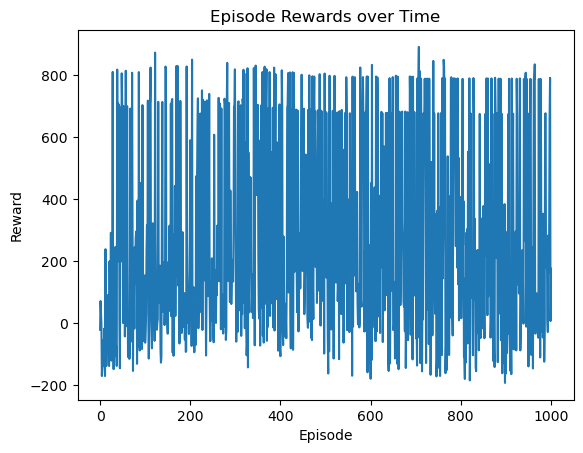

In [31]:
plot_learning_progress(log_dir)

In [34]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 27844), started 1:06:20 ago. (Use '!kill 27844' to kill it.)

In [ ]:
# Single environmen

log_dir = LOG_DIR+'MaskablePPO_1suit/' # same dir to compare tensorboard results

actions_limit = 1000

env1p = SpiderEnv(n_actions_limit=1000, _dtype=np.float32, _render_state_timeout=1_0000, 
                    _diagnostics_mode=0, vectorize_obs=False, mask_legal_actions=True,
                #rewards_limit=True,
                 n_suits=1,
                 
                rewards_policy ={"discover_card": 4,
                                 "free pile": 16,
                                 "extend sequence": 1,
                                 "deal cards": -0.5}
                   )  # must return action_mask in info
env1p = Monitor(env1p,log_dir)
env1p = ActionMasker(env1p, mask_fn)

model1p = MaskablePPO(
    "MlpPolicy",
    env1p,
    verbose=1,
    n_steps=2048,
    batch_size=actions_limit,#the whole game is used to update the policy, updates can be more stable than when games are splitted into smaller chunks
    learning_rate=3e-4,
    gamma=0.995,
    device="auto",
    tensorboard_log=log_dir
)

l = model1p.learn(total_timesteps=1000_000,callback=SpiderCallback())

In [ ]:

log_dir = LOG_DIR+'MaskablePPO/'

# Define the masking function
def mask_fn(env):
    return env.get_action_mask()  # must return np.ndarray


env = SpiderEnv(n_actions_limit=1_000, _dtype=np.float32, _render_state_timeout=1_000, 
                    _diagnostics_mode=1, vectorize_obs=True, mask_legal_actions=True,
                #rewards_limit=True,
                rewards_policy ={"discover_card": 4,
                                 "free pile": 16,
                                 "extend sequence": 1,
                                 "deal cards": -0.5}
                   )  # must return action_mask in info
env = Monitor(env, log_dir)
env = ActionMasker(env, mask_fn)

model = MaskablePPO(
    "MlpPolicy",
    env,
    verbose=1,
    n_steps=2048,
    batch_size=256,
    learning_rate=3e-4,
    gamma=0.995,
    device="auto",
    tensorboard_log=log_dir
)


model.learn(total_timesteps=1_000_000,callback=SpiderCallback())